## `inatall and imports'


In [ ]:
!pip install tensorflow # Install PyTorch with CUDA support
!pip install torch torchvision torchaudio
!pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv -y
!pip uninstall torch-geometric -y


In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")


PyTorch version: 2.5.0+cu121
CUDA available: True
CUDA version: 12.1


In [ ]:
# Install PyTorch Geometric dependencies with pre-built binaries
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

# Install torch-geometric
!pip install torch-geometric
!pip install torchinfo


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 52.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00


In [ ]:
import torch_geometric
from torch_geometric.data import Data
print("Torch Geometric version:", torch_geometric.__version__)


/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

Torch Geometric version: 2.6.1


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate

## Data Processing

In [ ]:
weather_data = pd.read_csv('Datasets/complete_KNN_dataset_corrected.csv')
topo_features = pd.read_csv('Datasets/topological_features_365d_gpus.csv')
soil_data= pd.read_csv('Datasets/table_static_data_selected.csv')

yield_soil = pd.read_csv('Datasets/corn2001_2023_yield_data.csv')
yield_data = yield_soil[['Year', 'County', 'Value']]

# yield_data = yield_data[~((yield_data['Year'] == 2012) & (yield_data['Value'] < 90))]
yield_data = yield_data[~(yield_data['County'] =='OTHER (COMBINED) COUNTIES')]
yield_data= yield_data.rename(columns={'County': 'county'})
soil_data = soil_data.rename(columns={'NAME_U': 'county'})
soil_data = soil_data[['county', 'aws0_5', 'aws5_20',
       'aws20_50', 'aws0_20', 'soc0_20', 'soc0_30',
       'nccpi3corn', 'slope_r', 'elev_r',
        'W_avg_silt', 'W_avg_clay']]
yield_data = yield_data.rename(columns={'Year': 'year'})
weather_data = weather_data.rename(columns={'Date': 'date'})
topo_features = topo_features.rename(columns={'County': 'county'})

In [ ]:
yield_data = yield_data.rename(columns={'Value': 'value_old'})

In [ ]:
yield_data['Value'] = yield_data['value_old']+ (2023-yield_data['year'])*2.3373

In [ ]:
yield_data

,year,county,value_old,Value
0,2023,OTHER COUNTIES,202.5,202.5000
1,2023,BARTHOLOMEW,195.0,195.0000
2,2023,BOONE,207.2,207.2000
3,2023,CLINTON,234.4,234.4000
4,2023,DECATUR,221.9,221.9000
...,...,...,...,...
1980,2001,PUTNAM,157.8,209.2206
1981,2001,TIPPECANOE,157.5,208.9206
1982,2001,VERMILLION,160.6,212.0206
1983,2001,VIGO,148.7,200.1206


In [ ]:
len(yield_data.county.unique())

93

In [ ]:
# Assuming 'yield_data' is already loaded, let's find duplicate (county, year) pairs.

# Identify duplicate county-year pairs
duplicate_pairs = yield_data[yield_data.duplicated(subset=['county', 'year'], keep=False)]

# Display the duplicate pairs to the user
duplicate_pairs


,year,county,value_old,Value


In [ ]:
yield_data

,year,county,value_old,Value
0,2023,OTHER COUNTIES,202.5,202.5000
1,2023,BARTHOLOMEW,195.0,195.0000
2,2023,BOONE,207.2,207.2000
3,2023,CLINTON,234.4,234.4000
4,2023,DECATUR,221.9,221.9000
...,...,...,...,...
1980,2001,PUTNAM,157.8,209.2206
1981,2001,TIPPECANOE,157.5,208.9206
1982,2001,VERMILLION,160.6,212.0206
1983,2001,VIGO,148.7,200.1206


In [ ]:
import geopandas as gpd

# Load the county shapefile
counties = gpd.read_file('Datasets/Census_County_TIGER00_IN.shp')
counties = counties.rename(columns={'NAME_U': 'county'})


In [ ]:
import pandas as pd
'''
# Assuming df_yield is your yield dataframe
# And all_counties is a list of all county names in your region/state
all_counties = soil_data['county'].unique()  # Use the list of all county names from weather_data

# Assuming 'Year' and 'county' are the columns that list the year and county names in df_yield
# Iterate over each unique year in the yield dataset
years = yield_data['year'].unique()

new_rows = []

for year in years:
    # Step 1: Filter data for the specific year
    year_data = yield_data[yield_data['year'] == year]

    # Identify counties already present for this specific year
    present_counties = year_data['county'].unique().tolist()

    # Step 2: Identify the missing counties for this specific year
    missing_counties = [county for county in all_counties if county not in present_counties]

    # Step 3: Extract the "Other counties" data from the year-specific dataframe
    # Handle different variations of the "Other counties" labels
    other_county_data = year_data[
        year_data['county'].str.contains(r'OTHER.*COUNTIES', case=False, na=False)
    ]

    # Ensure there is "Other counties" data for this year
    if other_county_data.empty:
        print(f"No 'Other counties' row found for year {year}.")
    else:
        # Step 4: Create new rows for the missing counties for this year
        for _, row in other_county_data.iterrows():
            for missing_county in missing_counties:
                new_row = row.copy()
                new_row['county'] = missing_county
                new_rows.append(new_row)

# Step 5: Convert the list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Step 6: Append new rows to the original yield_data
yield_data_expanded = pd.concat([yield_data, new_rows_df], ignore_index=True)

# Step 7: Reset the index if needed
yield_data_expanded.reset_index(drop=True, inplace=True)

# Print to confirm changes (optional)
yield_data_expanded
'''


'\n# Assuming df_yield is your yield dataframe\n# And all_counties is a list of all county names in your region/state\nall_counties = soil_data[\'county\'].unique()  # Use the list of all county names from weather_data\n\n# Assuming \'Year\' and \'county\' are the columns that list the year and county names in df_yield\n# Iterate over each unique year in the yield dataset\nyears = yield_data[\'year\'].unique()\n\nnew_rows = []\n\nfor year in years:\n    # Step 1: Filter data for the specific year\n    year_data = yield_data[yield_data[\'year\'] == year]\n\n    # Identify counties already present for this specific year\n    present_counties = year_data[\'county\'].unique().tolist()\n\n    # Step 2: Identify the missing counties for this specific year\n    missing_counties = [county for county in all_counties if county not in present_counties]\n\n    # Step 3: Extract the "Other counties" data from the year-specific dataframe\n    # Handle different variations of the "Other counties" lab

In [ ]:
valid_counties = set(yield_data['county']).intersection(
    set(soil_data['county']),
    set(weather_data['county']),
    set(topo_features['county']),
    set(weather_data['county'])
)

len(valid_counties)

80

In [ ]:
# Get the unique counties from weather_data
# valid_counties = weather_data['county'].unique()

# Filter soil_data to include only counties present in weather_data
soil_data_filtered = soil_data[soil_data['county'].isin(valid_counties)]
topo_features_filtered = topo_features[topo_features['county'].isin(valid_counties)]
# Filter yield_data to include only counties present in weather_data
yield_data_filtered = yield_data[yield_data['county'].isin(valid_counties)]
weather_data_filtered = weather_data[weather_data['county'].isin(valid_counties)]
# Now you have filtered versions of both soil_data and yield_data that contain only relevant counties
print(f"Filtered soil_data contains {len(soil_data_filtered)} rows")
print(f"Filtered yield_data contains {len(yield_data_filtered)} rows")
print(f"Filtered weather_data contains {len(weather_data_filtered)} rows")
print(f"Filtered topo_features contains {len(topo_features_filtered)} rows")

Filtered soil_data contains 80 rows
Filtered yield_data contains 1700 rows
Filtered weather_data contains 529693 rows
Filtered topo_features contains 1441 rows


In [ ]:
import pandas as pd

# Assuming weather_data is already loaded
weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])  # Ensure 'Date' column is in datetime format
weather_data_filtered['year'] = weather_data_filtered['date'].dt.year          # Extract year
weather_data_filtered['month'] = weather_data_filtered['date'].dt.month        # Extract month

# Filter weather data for April to August
weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])
weather_data_filtered = weather_data_filtered[(weather_data_filtered['date'].dt.month >= 4) & (weather_data_filtered['date'].dt.month <= 8)]

# Check if any data remains after filtering
if weather_data_filtered.empty:
    print("Warning: No data found for the April–August period.")
else:
    print(f"Data retained for April–August: {len(weather_data_filtered)} rows")



<ipython-input-17-40795f34f49f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])  # Ensure 'Date' column is in datetime format
<ipython-input-17-40795f34f49f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_filtered['year'] = weather_data_filtered['date'].dt.year          # Extract year
<ipython-input-17-40795f34f49f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Data retained for April–August: 221916 rows


<ipython-input-17-40795f34f49f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])


In [ ]:
# Get the unique counties from each dataset
weather_counties = set(weather_data_filtered['county'].unique())
soil_counties = set(soil_data_filtered['county'].unique())  # Use the filtered version
yield_counties = set(yield_data_filtered['county'].unique())  # Use the filtered version
topo_features_counties = set(topo_features_filtered['county'].unique())
# Check for differences
counties_in_weather_not_in_soil = weather_counties - soil_counties
counties_in_soil_not_in_weather = soil_counties - weather_counties

counties_in_weather_not_in_yield = weather_counties - yield_counties
counties_in_yield_not_in_weather = yield_counties - weather_counties

counties_in_weather_not_in_topo = weather_counties - topo_features_counties
counties_in_topo_not_in_weather = topo_features_counties - weather_counties

counties_in_yield_not_in_topo = yield_counties - topo_features_counties
counties_in_topo_not_in_yield = topo_features_counties - yield_counties

# Print the results
print(f"Counties in weather data but not in soil data: {counties_in_weather_not_in_soil}")
print(f"Counties in soil data but not in weather data: {counties_in_soil_not_in_weather}")

print(f"Counties in weather data but not in yield data: {counties_in_weather_not_in_yield}")
print(f"Counties in yield data but not in weather data: {counties_in_yield_not_in_weather}")

print(f"Counties in weather data but not in topo features: {counties_in_weather_not_in_topo}")
print(f"Counties in topo features but not in weather data: {counties_in_topo_not_in_weather}")

print(f"Counties in yield data but not in topo features: {counties_in_yield_not_in_topo}")
print(f"Counties in topo features but not in yield data: {counties_in_topo_not_in_yield}")



Counties in weather data but not in soil data: set()
Counties in soil data but not in weather data: set()
Counties in weather data but not in yield data: set()
Counties in yield data but not in weather data: set()
Counties in weather data but not in topo features: set()
Counties in topo features but not in weather data: set()
Counties in yield data but not in topo features: set()
Counties in topo features but not in yield data: set()


In [ ]:
# Check common counties and years
weather_data_filtered['county'] = weather_data_filtered['county'].str.strip()  # clean up names if needed
topo_features_filtered['county'] = topo_features_filtered['county'].str.strip()
yield_data_filtered['county'] = yield_data_filtered['county'].str.strip()
soil_data_filtered['county'] = soil_data_filtered['county'].str.strip()

# Check if all counties are present in each dataset
print(set(weather_data_filtered['county']).intersection(set(topo_features['county'])))
print(set(weather_data_filtered['county']).intersection(set(yield_data['county'])))
print(set(weather_data_filtered['county']).intersection(set(soil_data['county'])))


{'DELAWARE', 'SWITZERLAND', 'SPENCER', 'NOBLE', 'PERRY', 'TIPTON', 'PORTER', 'WAYNE', 'MADISON', 'WHITLEY', 'KOSCIUSKO', 'MARSHALL', 'OWEN', 'MARTIN', 'MONTGOMERY', 'LAWRENCE', 'RUSH', 'STEUBEN', 'PIKE', 'VIGO', 'JENNINGS', 'ALLEN', 'LA PORTE', 'FRANKLIN', 'POSEY', 'HENRY', 'WARRICK', 'CLINTON', 'FULTON', 'MARION', 'SULLIVAN', 'HANCOCK', 'JACKSON', 'JOHNSON', 'ELKHART', 'MORGAN', 'LAKE', 'LAGRANGE', 'BENTON', 'CARROLL', 'FOUNTAIN', 'RIPLEY', 'DUBOIS', 'JAY', 'DECATUR', 'SCOTT', 'CASS', 'JEFFERSON', 'DEARBORN', 'NEWTON', 'TIPPECANOE', 'BARTHOLOMEW', 'JASPER', 'CRAWFORD', 'PULASKI', 'KNOX', 'STARKE', 'BLACKFORD', 'WASHINGTON', 'DAVIESS', 'WABASH', 'VANDERBURGH', 'ORANGE', 'VERMILLION', 'PARKE', 'ADAMS', 'CLAY', 'HAMILTON', 'WHITE', 'GIBSON', 'MONROE', 'PUTNAM', 'HOWARD', 'HUNTINGTON', 'UNION', 'SHELBY', 'WELLS', 'GRANT', 'BOONE', 'RANDOLPH'}
{'DELAWARE', 'SWITZERLAND', 'SPENCER', 'NOBLE', 'PERRY', 'TIPTON', 'PORTER', 'WAYNE', 'MADISON', 'WHITLEY', 'KOSCIUSKO', 'MARSHALL', 'OWEN', 'MARTIN

<ipython-input-19-34f1297e1bdc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topo_features_filtered['county'] = topo_features_filtered['county'].str.strip()
<ipython-input-19-34f1297e1bdc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yield_data_filtered['county'] = yield_data_filtered['county'].str.strip()
<ipython-input-19-34f1297e1bdc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [ ]:
weather_data_filtered

,date,county,mergedmax_temp,mergedmean_temp,mergedmin_temp,merged_precip,gdd,year,month
90,2001-04-01,ADAMS,48.0,41.0,34.0,0.190000,0.0,2001,4
91,2001-04-02,ADAMS,59.0,43.5,28.0,0.000000,0.0,2001,4
92,2001-04-03,ADAMS,54.0,47.0,40.0,0.000000,0.0,2001,4
93,2001-04-04,ADAMS,59.0,45.5,32.0,0.000000,0.0,2001,4
94,2001-04-05,ADAMS,73.0,53.0,33.0,0.000000,3.0,2001,4
...,...,...,...,...,...,...,...,...,...
535044,2023-08-27,WHITLEY,75.0,64.0,53.0,0.000000,14.0,2023,8
535045,2023-08-28,WHITLEY,76.0,63.5,51.0,0.000000,13.5,2023,8
535046,2023-08-29,WHITLEY,80.0,65.5,51.0,0.020000,15.5,2023,8
535047,2023-08-30,WHITLEY,71.0,59.5,48.0,0.071667,9.5,2023,8


In [ ]:
# Ensure weather_features columns are present and apply MinMaxScaler only if data exists
weather_features = ['mergedmax_temp', 'mergedmean_temp', 'mergedmin_temp', 'merged_precip', 'gdd']
missing_features = [feature for feature in weather_features if feature not in weather_data.columns]
if missing_features:
    print(f"Missing weather features: {missing_features}")
else:
    scaler = MinMaxScaler()
    weather_data[weather_features] = scaler.fit_transform(weather_data[weather_features])
    print("Weather data scaled successfully.")
#copy this later

Weather data scaled successfully.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Ensure consistent casing in county names
for df in [yield_data_filtered, topo_features_filtered, weather_data_filtered, soil_data_filtered]:
    df['county'] = df['county'].str.upper()

# Identify common county-year pairs across yield, topo, and weather datasets
common_pairs = set(yield_data_filtered[['county', 'year']].apply(tuple, axis=1)) \
               & set(topo_features_filtered[['county', 'year']].apply(tuple, axis=1)) \
               & set(weather_data_filtered[['county', 'year']].apply(tuple, axis=1))

# Filter each dataset based on common county-year pairs
yield_data_filtered = yield_data_filtered[yield_data_filtered[['county', 'year']].apply(tuple, axis=1).isin(common_pairs)]
topo_features_filtered = topo_features_filtered[topo_features_filtered[['county', 'year']].apply(tuple, axis=1).isin(common_pairs)]
weather_data_filtered = weather_data_filtered[weather_data_filtered[['county', 'year']].apply(tuple, axis=1).isin(common_pairs)]
soil_data_filtered = soil_data_filtered[soil_data_filtered['county'].isin(yield_data_filtered['county'].unique())]  # Soil by county only

# Filter weather data to only include April-August entries
weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])
weather_data_filtered = weather_data_filtered[(weather_data_filtered['date'].dt.month >= 4) & (weather_data_filtered['date'].dt.month <= 8)]

# Scale features
scaler_weather = MinMaxScaler()
scaler_topo = MinMaxScaler()
scaler_soil = MinMaxScaler()

# Define feature columns
weather_features = ['mergedmax_temp', 'mergedmean_temp', 'mergedmin_temp', 'merged_precip', 'gdd']
topo_features_cols = topo_features_filtered.columns[2:]  # All columns except county, year
soil_features = soil_data_filtered.columns[1:]  # All columns except county

# Apply scaling
weather_data_filtered[weather_features] = scaler_weather.fit_transform(weather_data_filtered[weather_features])
topo_features_filtered[topo_features_cols] = scaler_topo.fit_transform(topo_features_filtered[topo_features_cols])
soil_data_filtered[soil_features] = scaler_soil.fit_transform(soil_data_filtered[soil_features])

# Organize weather data into sequences for each county-year pair
weather_sequences = {}
for (county, year), group in weather_data_filtered.groupby(['county', 'year']):
    sequence = group[weather_features].values
    if len(sequence) == 153:  # Ensure the sequence length is consistent (153 days for April-August)
        weather_sequences[(county, year)] = sequence

# Convert topo and soil data into dictionary lookups
topo_features_dict = topo_features_filtered.set_index(['county', 'year']).to_dict(orient='index')
soil_data_dict = soil_data_filtered.set_index('county').to_dict(orient='index')

# Filter valid pairs to ensure no missing data
valid_pairs = [pair for pair in common_pairs if pair in weather_sequences]

# Prepare Final Dataset
# Weather data remains unflattened for temporal models
X_weather = np.array([weather_sequences[(county, year)] for county, year in valid_pairs])

# Static features (topo and soil) - ensure shape alignment for concatenation
X_topo = np.array([list(topo_features_dict[(county, year)].values()) for county, year in valid_pairs])
X_soil = np.array([list(soil_data_dict[county].values()) for county, _ in valid_pairs])

# Targets
y = yield_data_filtered[yield_data_filtered[['county', 'year']].apply(tuple, axis=1).isin(valid_pairs)]['Value'].values

# Combine weather, topo, and soil features for Transformer
# Assuming Transformer will separately process temporal and static features
X_static = np.hstack([X_topo, X_soil])

# X_weather shape: (num_samples, 153, num_weather_features)
# X_static shape: (num_samples, num_static_features)

# Save data or pass directly to the model


<ipython-input-22-92fedc1c4656>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['county'] = df['county'].str.upper()
<ipython-input-22-92fedc1c4656>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered['date'])
<ipython-input-22-92fedc1c4656>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

## Transformr model

Using device: cuda
Train size: 1034, Validation size: 259, Test size: 50
Epoch [1/1500], Train RMSE: 188.7603, Validation RMSE: 191.3248
Epoch [2/1500], Train RMSE: 187.1674, Validation RMSE: 188.6387
Epoch [3/1500], Train RMSE: 182.7302, Validation RMSE: 181.9212
Epoch [4/1500], Train RMSE: 172.8433, Validation RMSE: 167.9351
Epoch [5/1500], Train RMSE: 154.0552, Validation RMSE: 143.3129
Epoch [6/1500], Train RMSE: 123.9240, Validation RMSE: 106.5542
Epoch [7/1500], Train RMSE: 83.6219, Validation RMSE: 62.7693
Epoch [8/1500], Train RMSE: 44.6243, Validation RMSE: 31.6630
Epoch [9/1500], Train RMSE: 27.0396, Validation RMSE: 24.5495
Epoch [10/1500], Train RMSE: 25.7683, Validation RMSE: 24.2806
Epoch [11/1500], Train RMSE: 25.7820, Validation RMSE: 24.3326
Epoch [12/1500], Train RMSE: 25.9464, Validation RMSE: 24.3161
Epoch [13/1500], Train RMSE: 25.7826, Validation RMSE: 24.2349
Epoch [14/1500], Train RMSE: 26.1060, Validation RMSE: 24.3300
Epoch [15/1500], Train RMSE: 25.9476, Vali

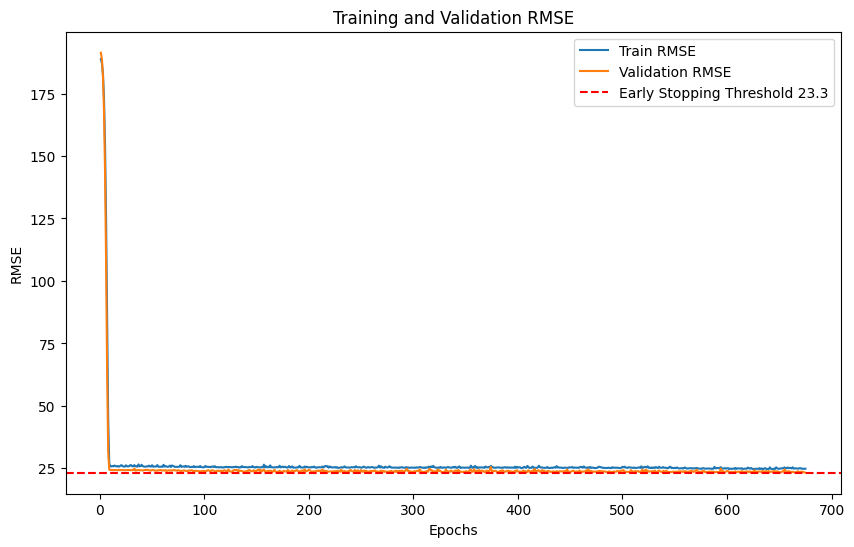

In [ ]:
seed = 1
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class TransformerModel(nn.Module):
    def __init__(self, weather_input_dim, static_input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout, output_dim):
        super(TransformerModel, self).__init__()

        # Transformer for temporal features
        self.weather_embedding = nn.Linear(weather_input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 153, d_model))
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout),
            num_layers=num_encoder_layers
        )
        self.temporal_fc1 = nn.Linear(d_model, d_model // 2)
        # self.temporal_fc2 = nn.Linear(d_model // 2, d_model // 4)

        # Fully connected layers for static features
        self.static_fc1 = nn.Linear(static_input_dim, d_model // 2)
        # self.static_fc2 = nn.Linear(d_model // 2, d_model // 4)

        # Final output layers after concatenation
        combined_dim = (d_model // 2) * 2  # Since we're concatenating temporal and static parts
        self.fc1 = nn.Linear(combined_dim, combined_dim // 2)
        self.fc_out = nn.Linear(combined_dim // 2, output_dim)

    def forward(self, weather_seq, static_features):
        # Temporal processing
        weather_embedded = self.weather_embedding(weather_seq)
        weather_embedded += self.pos_encoder
        temporal_output = self.transformer_encoder(weather_embedded)
        temporal_output = torch.mean(temporal_output, dim=1)  # Global average pooling
        temporal_output = torch.relu(self.temporal_fc1(temporal_output))
        # temporal_output = torch.relu(self.temporal_fc2(temporal_output))

        # Static feature processing
        static_output = torch.relu(self.static_fc1(static_features))
        # static_output = torch.relu(self.static_fc2(static_output))

        # Concatenate and predict
        combined = torch.cat((temporal_output, static_output), dim=1)
        combined = torch.relu(self.fc1(combined))
        output = self.fc_out(combined)
        return output



# Instantiate model
weather_input_dim = X_weather.shape[2]
static_input_dim = X_static.shape[1]
output_dim = 1
d_model = 64
nhead = 4
num_encoder_layers = 4
dim_feedforward = 128
dropout = 0.0

model = TransformerModel(weather_input_dim, static_input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout, output_dim).to(device)

# Prepare the dataset
weather_tensor = torch.tensor(X_weather, dtype=torch.float32).to(device)
static_tensor = torch.tensor(X_static, dtype=torch.float32).to(device)
target_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

# Create DataLoader
batch_size = 32
dataset = TensorDataset(weather_tensor, static_tensor, target_tensor)

# Define sizes for train, validation, and test sets
test_size = 50
train_val_size = len(dataset) - test_size

# Split train_val_size into train and validation sets (80% train, 20% val)
train_size = int(0.8 * train_val_size)
val_size = train_val_size - train_size

# Perform the splits
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)

# Training loop

epochs = 1500
patience_counter = 0
early_stopping_threshold = 23.3  # Adjust this threshold as needed, trial and error method to minimize the error
train_rmse, val_rmse = [], []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for weather_batch, static_batch, target_batch in train_loader:
        weather_batch, static_batch, target_batch = weather_batch.to(device), static_batch.to(device), target_batch.to(device)
        optimizer.zero_grad()
        outputs = model(weather_batch, static_batch)
        loss = criterion(outputs, target_batch)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.01)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_rmse_epoch = np.sqrt(running_loss / len(train_loader))
    train_rmse.append(train_rmse_epoch)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for weather_batch, static_batch, target_batch in val_loader:
            weather_batch, static_batch, target_batch = weather_batch.to(device), static_batch.to(device), target_batch.to(device)
            outputs = model(weather_batch, static_batch)
            val_loss += criterion(outputs, target_batch).item()

    val_rmse_epoch = np.sqrt(val_loss / len(val_loader))
    val_rmse.append(val_rmse_epoch)

    print(f"Epoch [{epoch + 1}/{epochs}], Train RMSE: {train_rmse_epoch:.4f}, Validation RMSE: {val_rmse_epoch:.4f}")

    # Early stopping condition
    if val_rmse_epoch < early_stopping_threshold:
        print(f"Early stopping triggered at epoch {epoch + 1} with Validation RMSE: {val_rmse_epoch:.4f}")
        break

# Plot training and validation RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, label='Train RMSE')
plt.plot(range(1, len(val_rmse) + 1), val_rmse, label='Validation RMSE')
plt.axhline(y=23, color='r', linestyle='--', label=f'Early Stopping Threshold {early_stopping_threshold}')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training and Validation RMSE')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'models/transformer_trained_model.pth')

In [ ]:
# Define the model architecture
loaded_model = TransformerModel(
    weather_input_dim=weather_tensor.shape[2],  # Number of weather features
    static_input_dim=static_tensor.shape[1],    # Number of static features
    d_model=64,  # This should match what was used during training
    nhead=4,
    num_encoder_layers=4,
    dim_feedforward=128,
    dropout=0.0,
    output_dim=1
).to(device)

# Load the state_dict into the model
loaded_model.load_state_dict(torch.load('models/transformer_trained_model.pth'))

# Set the model to evaluation mode
loaded_model.eval()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-38-ac25bf9fe632>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you st

TransformerModel(
  (weather_embedding): Linear(in_features=5, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (temporal_fc1): Linear(in_features=64, out_features=32, bias=True)
  (static_fc1): Linear(in_features=29, out_features=32, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  

R^2: 0.0095
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.4625
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.500
Time:                        19:09:06   Log-Likelihood:                -229.70
No. Observations:                  50   AIC:                             463.4
Df Residuals:                      48   BIC:                             467.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.0030    113.574      0.

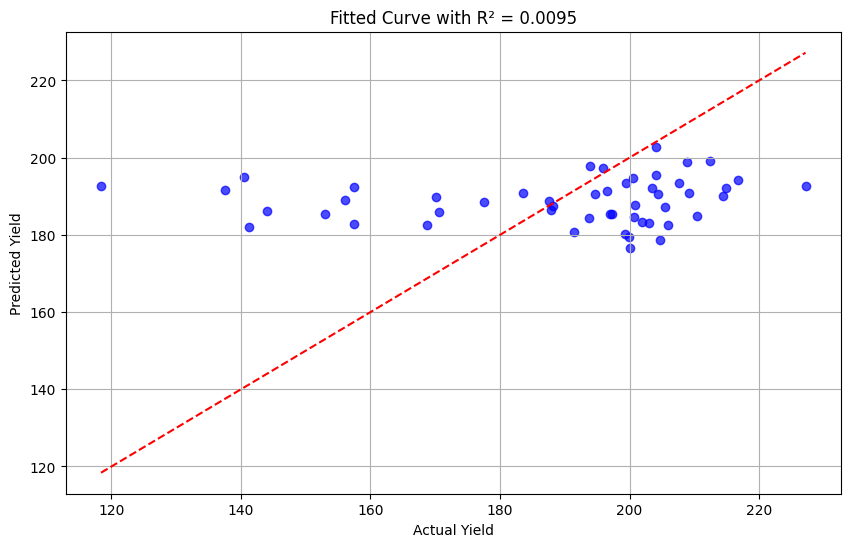

            County-Year  Actual Yield  Predicted Yield
0          (KNOX, 2023)    200.484894       194.838547
1         (WHITE, 2017)    193.834106       197.909409
2        (JASPER, 2004)    187.561096       188.739029
3         (ALLEN, 2013)    205.484894       187.222122
4       (JOHNSON, 2020)    201.945999       183.358994
5       (HANCOCK, 2002)    170.083298       189.732849
6        (STARKE, 2011)    156.083298       188.927872
7         (BOONE, 2020)    199.971405       179.498291
8          (RUSH, 2008)    199.423798       193.317795
9       (ELKHART, 2006)    216.722198       194.180664
10  (BARTHOLOMEW, 2012)    200.645996       184.735992
11     (LAGRANGE, 2009)    187.937302       186.333908
12        (PARKE, 2002)    118.383301       192.748871
13       (DUBOIS, 2010)    177.549194       188.468369
14       (TIPTON, 2005)    227.186493       192.732559
15       (MORGAN, 2006)    200.845993       187.717941
16  (VANDERBURGH, 2015)    157.498398       192.423508
17        

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
# Collect predictions and actual values
y_pred = []
y_true = []

with torch.no_grad():
    for weather_batch, static_batch, target_batch in test_loader:
        weather_batch, static_batch = weather_batch.to(device), static_batch.to(device)
        outputs = loaded_model(weather_batch, static_batch)
        y_pred.extend(outputs.cpu().numpy().flatten())
        y_true.extend(target_batch.cpu().numpy().flatten())

# Calculate R²
# Ensure predictions and true values are arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)


# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Add a constant for the intercept
y_pred_with_const = sm.add_constant(y_pred)

# Fit the regression model
model = sm.OLS(y_true, y_pred_with_const).fit()

# Print the R^2 value
print(f"R^2: {model.rsquared:.4f}")

# Optional: Display model summary
print(model.summary())

# Plot fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.7, color='blue')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # Reference line for perfect fit
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Fitted Curve with R² = {model.rsquared:.4f}')
plt.grid(True)
plt.show()

# Map predictions back to county-year for analysis
test_pairs = [valid_pairs[i] for i in range(len(valid_pairs)) if i >= len(train_loader.dataset) + len(val_loader.dataset)]

# Create a DataFrame for better visualization
results_df = pd.DataFrame({
    'County-Year': test_pairs[:len(y_pred)],  # Ensure it matches the number of predictions
    'Actual Yield': y_true,
    'Predicted Yield': y_pred
})

# Display the first few rows
print(results_df)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
# print(f"R^2: {r2:.4f}")
